In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline



Using TensorFlow backend.


In [3]:
def Hbeta(D = np.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X = np.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point ", i, " of ", n, "...")

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax =  np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries = tries + 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: ", np.mean(np.sqrt(1 / beta)))
    return P


def pca(X = np.array([]), no_dims = 50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:,0:no_dims])
    return Y


def tsne(X = np.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4;                                    # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration ", (iter + 1), ": error is ", C)

        # Stop lying about P-values
        if iter == 100:
            P = P / 4

    # Return solution
    return Y


In [4]:
carina = np.load('/Users/crjones/Documents/Science/HargisDDRF/carina_224.npy')

In [5]:
carina.shape

(224, 224, 3, 2240)

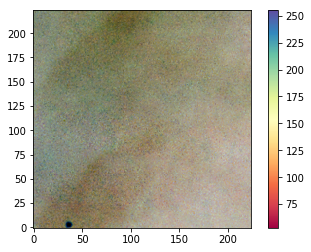

In [6]:
plt.imshow(carina[:,:,:,10])
plt.colorbar()
plt.show()

In [7]:
def histeq(im,nbr_bins=256):
  """  Histogram equalization of a grayscale image. """

  # get image histogram
  imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
  cdf = imhist.cumsum() # cumulative distribution function
  cdf = 255 * cdf / cdf[-1] # normalize

  # use linear interpolation of cdf to find new pixel values
  im2 = np.interp(im.flatten(),bins[:-1],cdf)

  return im2.reshape(im.shape)

#if True:
#    for ii in range(carina.shape[3]):
#        carina[:,:,:,ii] = histeq(carina[:,:,:,ii])
#else:
#    carina[:,:,:,0] = np.log(carina[:,:,:,0]+1)

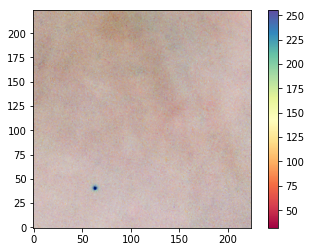

In [8]:
plt.imshow(carina[:,:,:,0])
plt.colorbar()
plt.show()

In [22]:
n = 30
x = carina[0:224,0:224,:,n]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(x.shape)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
predictions = decode_predictions(preds, top=3)[0]
print('\nPredicted:')
for tt in predictions:
    print(tt)
    
y = np.zeros(x.shape)
y[0,:,:,0] = x[0,:,:,0].T
y[0,:,:,1] = x[0,:,:,1].T
y[0,:,:,2] = x[0,:,:,2].T
preds = model.predict(y)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
predictions = decode_predictions(preds, top=3)[0]
print('\nPredicted:')
for tt in predictions:
    print(tt)
    
    

(1, 224, 224, 3)

Predicted:
('n09472597', 'volcano', 0.3123183)
('n09288635', 'geyser', 0.06746123)
('n09256479', 'coral_reef', 0.051603783)

Predicted:
('n09472597', 'volcano', 0.47994906)
('n09256479', 'coral_reef', 0.038616605)
('n03888257', 'parachute', 0.029546097)


In [19]:
y.shape

(1, 224, 224, 3)